# Training Pipeline using Title and Body Model

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from nltk.tokenize import word_tokenize
from toolbox.data_prep_helpers import *
from toolbox.evaluation import *

#from models.lstm_classifier import create_model
from models.title_body_lstm import create_model as tb_create_model

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
import numpy as np
import time



In [15]:
data_path = "../data/pythonquestions/"
ft_path = "sg_model.ft"  # set this to None if you want to train your own fasttext embeddings
n_top_labels = 100
n_epochs = 300
max_question_words = 100
sample_size = -1  # set to -1 to use entire data
normalize_embeddings = True
use_titles = False

tokenized_field = "q_all_body_tokenized"
content_field = "Body_q"

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dschr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load Data

In [4]:
df = load_data(data_path, ignore_cache=False, tokenized_field=tokenized_field, content_field=content_field)
df.shape

loading data from cached pickle


(607282, 5)

In [5]:
sample = df.sample(sample_size) if sample_size > 0 else df
del df
sample.head()

,Id,Title,Body_q,tags,q_all_body_tokenized
0,469,How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...,"[python, osx, fonts, photoshop]","[i, am, using, the, photoshop, 's, javascript,..."
1,502,Get a preview JPEG of a PDF on Windows?,I have a cross-platform (Python) application w...,"[python, windows, image, pdf]","[i, have, a, cross-platform, (, python, ), app..."
2,535,Continuous Integration System for a Python Cod...,I'm starting work on a hobby project with a py...,"[python, continuous-integration, extreme-progr...","[i, 'm, starting, work, on, a, hobby, project,..."
3,594,cx_Oracle: How do I iterate over a result set?,There are several ways to iterate over a resul...,"[python, sql, database, oracle, cx-oracle]","[there, are, several, ways, to, iterate, over,..."
4,683,Using 'in' to match an attribute of Python obj...,I don't remember whether I was dreaming or not...,"[python, arrays, iteration]","[i, do, n't, remember, whether, i, was, dreami..."


In [6]:
# remove_html_tags(chunk, ["Body_q"])
#print(f"{i}: generating question level tokens")
sample["q_title_tokenized"] = sample["Title"].apply(generate_question_level_tokens)

### Clean Data

In [7]:
sample.shape

(607282, 6)

In [7]:
# we have some nans in our tags which break target encoding
print(sample.shape)
sample = sample[sample["tags"].apply(lambda tags: all([isinstance(t, str) for t in tags]))]
print(sample.shape)


# Reduce the number of tags and adjust dataframe accordingly
sample = reduce_number_of_tags(sample, n_top_labels)
sample.shape

(607282, 6)
(606841, 6)
deleting element python from top_tags


(425658, 6)

In [8]:
sample["tags"].head(5)

0               [osx]
1    [windows, image]
3     [sql, database]
4            [arrays]
5       [django, oop]
Name: tags, dtype: object

In [9]:
#Remove Questions that have more than "max_question_words" words and questions with no words
data = sample[sample[tokenized_field].apply(len) <= max_question_words]
data = data[data["q_all_body_tokenized"].apply(len) > 0]


In [10]:
data.shape

(97627, 6)

In [11]:
print(data.shape)
idx = np.random.randint(0,len(data),100)
validation_questions = data.iloc[idx]
data = data.drop(validation_questions.index)


(97627, 6)


In [12]:
print(data.shape)
print(validation_questions.shape)

(97527, 6)
(100, 6)


### Load or create FastText embeddings

In [16]:
if ft_path is not None:
    wv = load_fasttext_embeddings(ft_path)
else:
    wv = create_FastText_embeddings(df, content_field)   
wv.init_sims()

### Prepare Data

In [17]:
# Apply word embeddings, insert paddings and encode the labels with an MultiLabelBinarizer

X_t = data["q_title_tokenized"].apply(lambda x: np.array([wv.word_vec(w, use_norm=normalize_embeddings) for w in x]))
X_b = data["q_all_body_tokenized"].apply(lambda x: np.array([wv.word_vec(w, use_norm=normalize_embeddings) for w in x]))

padding_element = np.array([0.0] * X_t.iloc[0].shape[-1])

X_t = pad_sequences(X_t, padding="post", dtype='float32', value=padding_element)
X_b = pad_sequences(X_b, padding="post", dtype='float32', value=padding_element)
print(X_t.shape)
print(X_b.shape)

label_encoder = MultiLabelBinarizer()
label_encoder.fit(data["tags"])
y = label_encoder.transform(data["tags"])
print(y.shape)

(97527, 40, 100)
(97527, 100, 100)
(97527, 100)


### Grid Search
Apply grid search to find best hyperparameter combination

In [12]:
from toolbox.training import grid_search_es

search_params = {
    # conduct big grid search with these params
    "lstm_layer_size": [256,128],
    "lstm_dropout": [0.0,0.2,0.4],
    "num_mid_dense": [1, 0],
    
    # test grid search with these params (comment out for actual run)
    #"lstm_layer_size": [16],
    #"lstm_dropout": [0.0],
    #"num_mid_dense": [1, 0],
    # don#t change
    "output_dim": [y.shape[-1]]
}

all_hists = grid_search_es([X_b, X_t], y, tb_create_model, search_params, max_epochs=150)


{'lstm_layer_size': 256, 'lstm_dropout': 0.0, 'num_mid_dense': 1, 'output_dim': 100}
Train on 78101 samples, validate on 19526 samples
Epoch 1/150
  128/78101 [..............................] - ETA: 30:02 - loss: 0.0694 - accuracy: 0.9855 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00Train on 78101 samples, validate on 19526 samples
Epoch 1/150
  128/78101 [..............................] - ETA: 32:47 - loss: 0.0673 - accuracy: 0.9861 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00average min val_loss: 0.06622259205196354 -- epochs: [98, 90] -- time: 1027.04 seconds
{'lstm_layer_size': 256, 'lstm_dropout': 0.0, 'num_mid_dense': 0, 'output_dim': 100}
Train on 78101 samples, validate on 19526 samples
Epoch 1/150
  128/78101 [..............................] - ETA: 30:45 - loss: 0.0760 - accuracy: 0.9861 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00Train on 78101 samples, validate on 19526 samples
Epoch 1/150
  128/78101 [..............................] - ETA: 29:15 - loss: 0.0824

MemoryError: 

We set our model-paramter to the results of the grid search. Feel free to run it on your own or set parameters manually.

In [18]:
best_params = {'lstm_layer_size': 256, 'lstm_dropout': 0.0, 'num_mid_dense': 1, 'output_dim': 100}

In [58]:
# Chooses the parameter configuration, which lead to the lowest loss during the grid search
best_params, best_hist, best_loss = min(all_hists, key=lambda x: x[2])

epoch_lengths = [len(h["val_loss"]) for h in best_hist]
print(f"best combindation: {best_params}")
print(f"avg min val_loss: {best_loss} -- epoch counts: {epoch_lengths}")

best combindation: {'lstm_layer_size': 128, 'lstm_dropout': 0.4, 'num_mid_dense': 1, 'output_dim': 100}
avg min val_loss: 0.0663479853600407 -- epoch counts: [100, 93]


### Create and Train Model

In [19]:
# Train and test split with two datasets. Requires the zip to make the split for the question body and the question title
X_train_z, X_test_z, y_train, y_test = train_test_split(list(zip(X_b, X_t)), y, test_size=0.2)
X_train = list(zip(*X_train_z))
X_test = list(zip(*X_test_z))
#Convert to numpy arrays 
X_train=[np.array(X_train[0]), np.array(X_train[1])]
X_test=[np.array(X_test[0]), np.array(X_test[1])]
print(X_train[0].shape)

(78021, 100, 100)


In [20]:
model = tb_create_model(**best_params)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 100)    0           input_1[0][0]                    
__________________________________________________________________________________________________
masking_1 (Masking)             (None, None, 100)    0           input_2[0][0]                    
______________________________________________________________________________________________

In [21]:
# If you are working on linux or windows, pay attention to the file paths "/" and "\\" respectively

import datetime

model_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir="logs\\fit\\" + model_name

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, verbose=0, restore_best_weights=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1),
    # ModelCheckpoint(filepath=f"checkpoints\\{model_name}", monitor="val_loss", verbose=0)
]

model.fit(x=X_train, y=y_train, batch_size=128, epochs = 300, validation_data=[X_test, y_test], callbacks=callbacks)

Train on 78021 samples, validate on 19506 samples
Epoch 1/300
78021/78021 [==============================] - 147s 2ms/sample - loss: 0.0694 - accuracy: 0.9840 - val_loss: 0.0505 - val_accuracy: 0.9878
Epoch 2/300
78021/78021 [==============================] - 34s 438us/sample - loss: 0.0450 - accuracy: 0.9883 - val_loss: 0.0410 - val_accuracy: 0.9887
Epoch 3/300
78021/78021 [==============================] - 31s 403us/sample - loss: 0.0383 - accuracy: 0.9893 - val_loss: 0.0365 - val_accuracy: 0.9897
Epoch 4/300
78021/78021 [==============================] - 32s 408us/sample - loss: 0.0348 - accuracy: 0.9900 - val_loss: 0.0341 - val_accuracy: 0.9902
Epoch 5/300
78021/78021 [==============================] - 32s 416us/sample - loss: 0.0326 - accuracy: 0.9905 - val_loss: 0.0326 - val_accuracy: 0.9906
Epoch 6/300
78021/78021 [==============================] - 33s 426us/sample - loss: 0.0312 - accuracy: 0.9909 - val_loss: 0.0317 - val_accuracy: 0.9908
Epoch 7/300
78021/78021 [==============

Model Evaluation

normalize_embeddings = True, learning_rate = 1, vocab_size = None, epochs=300
Parameter Settings:
 Sample size = -1, Max. number of words per question = 100, Number of Top Labels used = 100

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 100)    0           input_1[0][0]                    
___________________________________________________________________________________

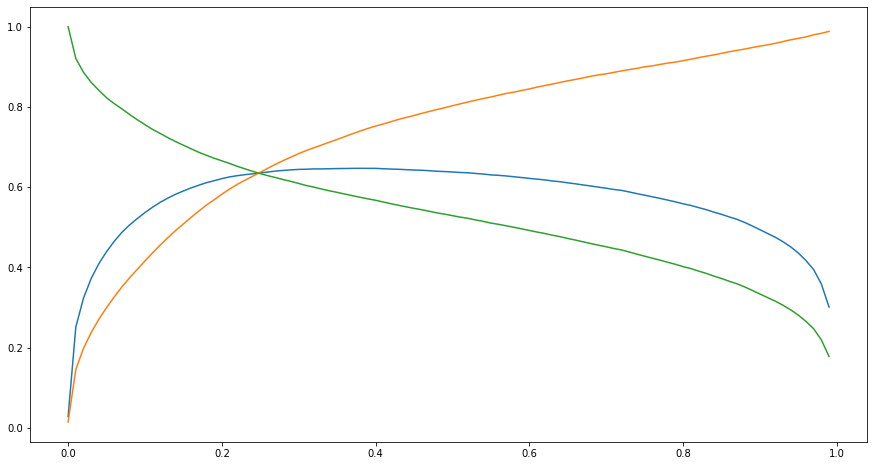


Metrics with optimized threshold of 0.38
 Macro Evaluation: f1_Score= 0.5476427858927477 , Recall = 0.5003593326350425 , Precision = 0.6480929682937218
 Micro Evaluation: f1_Score= 0.6468479423048702 , Recall = 0.5746265877006742 , Precision = 0.7398331095338576


In [27]:
predictions = model.predict(X_test)
opt_thres = output_evaluation(model, sample_size, max_question_words, n_top_labels, y_test, predictions, normalize_embeddings, 1, None, n_epochs)

### Looking at some examples

In [25]:
X_val_t = validation_questions["q_title_tokenized"].apply(lambda x: np.array([wv.word_vec(w, use_norm=normalize_embeddings) for w in x]))
X_val_b = validation_questions["q_all_body_tokenized"].apply(lambda x: np.array([wv.word_vec(w, use_norm=normalize_embeddings) for w in x]))

X_val_t = pad_sequences(X_val_t, padding="post", dtype='float32', value=padding_element, maxlen=X_t.shape[1])
X_val_b = pad_sequences(X_val_b, padding="post", dtype='float32', value=padding_element)

print(X_val_t.shape)
print(X_val_b.shape)

y_val = label_encoder.transform(validation_questions["tags"])
print(y_val.shape)


(100, 40, 100)
(100, 100, 100)
(100, 100)


In [28]:
predictions = model.predict([X_val_b, X_val_t])

l_pred = label_encoder.inverse_transform(binarize_model_output(predictions, threshold=opt_thres))
l_true = label_encoder.inverse_transform(y_val)
raw_texts = validation_questions[content_field]
titles = validation_questions["Title"]

for pred, act, raw_txt, title in zip(l_pred, l_true, raw_texts, titles):
    print(f"TRUE: {act}\nPREDICTION: {pred}\n")
    print(f"{title}\n")
    print(raw_txt)
    print(f"--------------------------\n")


TRUE: ('file',)
PREDICTION: ()

Homework - Printing lines of a file between two line numbers

Using Python, how do I print the lines of a text file, given a starting and ending line number?
I have come up with a function, but this doesn't work.
def printPart(src, des, varFile):
    returnLines = ""
    for curLine in range(src, des):
        returnLines += linecache.getline(varFile, curLine)
    return returnLines


--------------------------

TRUE: ('pandas',)
PREDICTION: ('matplotlib', 'pandas')

Plot series different frequencies

I have some time series, for which I created both quarterly and annual sums. I wanted to plot the two together, but the plot only showed the more frequent one. merged.plot() gives:

Here's some sample data.
>>> merged.head()
           shopping_weightedQ             shopping_weightedA            
status                    emp       unemp                emp       unemp
date                                                                    
2003-01-01       